# MNIST Point Cloud Classification

This task attempts to classify a set of 2D-points in the shape of a number. Using the MNIST dataset, point clouds are generated with a random number of points.

Note: the datasets are not included in this repository. Instead, they need to be generated using the [MNIST Point Cloud](https://github.com/DLii-Research/mnist-pointcloud) library.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer

## Strategy

Grab the appropriate compute device(s).

In [5]:
DEVICE = "gpu:0"
MULTI_GPU = False

In [6]:
if MULTI_GPU:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(DEVICE)

In [11]:
class MaxRegressionSetTransformer(keras.models.Model):
#     def __init__(self, input_shape, num_outputs, num_induce, embed_dim, num_heads, ff_dim):
    def __init__(self):
        super(MaxRegressionSetTransformer, self).__init__()
        
        # Encoder
        inp = keras.layers.Input((None, 1))
        out = keras.layers.Dense(64)(inp)
        out = SetAttentionBlock(64, 64, 4)(out)
        out = SetAttentionBlock(64, 64, 4)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, 64))
        out = PoolingByMultiheadAttention(1, 64, 1)(inp)
        out = keras.layers.Dense(1)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

In [12]:
def gen_data(batch_size, length=5, test=False):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y

In [13]:
with strategy.scope():
    model = MaxRegressionSetTransformer()
    model.compile(loss=keras.losses.MeanAbsoluteError())

In [14]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [17]:
with strategy.scope():
    history = model.fit(x, y, epochs=500, verbose=0)

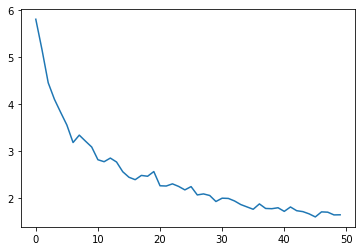

In [21]:
plt.plot(history.history["loss"][::10])

---
## 100-Element Point Clouds

In [22]:
# Point Clouds
with np.load("./datasets/mnist_point_cloud_train_100.npz") as f:
    x_train = f[list(f.keys())[0]]
    
with np.load("../datasets/mnist_point_cloud_test_100.npz") as f:
    x_test = f[list(f.keys())[0]]

# Labels
(_, y_train_labels), (_, y_test_labels) = keras.datasets.mnist.load_data()

# One-hot encoded labels
y_train = np.zeros((y_train_labels.size, y_train_labels.max()+1))
y_train[np.arange(y_train_labels.size), y_train_labels] = 1
y_test = np.zeros((y_test_labels.size, y_test_labels.max()+1))
y_test[np.arange(y_test_labels.size), y_test_labels] = 1

_ = None # Free memory

In [23]:
x_train.shape, x_test.shape

((60000, 100, 2), (10000, 100, 2))

In [24]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### Model Architecture

In [27]:
class PointCloudSetTransformer(keras.models.Model):
    def __init__(self):
        super(PointCloudSetTransformer, self).__init__()
        embed_dim = 64
        num_induce = 32
        num_heads = 4
        
        # Encoder
        inp = keras.layers.Input((None, 2))
        out = keras.layers.Dense(embed_dim)(inp)
        out = settransformer.InducedSetAttentionBlock(embed_dim, num_heads, num_induce)(out)
        out = settransformer.InducedSetAttentionBlock(embed_dim, num_heads, num_induce)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, embed_dim))
        out = keras.layers.Dropout(0.5)(inp)
        out = settransformer.PoolingByMultiHeadAttention(1, embed_dim, 1)(out)
        out = keras.layers.Dropout(0.5)(out)
        out = keras.layers.Dense(10)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

In [30]:
with strategy.scope():
    model = PointCloudSetTransformer()
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

In [31]:
model(x_train[:1])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.8533765 ,  0.9214091 ,  0.9969456 , -0.37074822, -1.6455694 ,
       -0.97620887, -1.0441594 , -1.5369172 ,  0.28667808, -1.3333459 ],
      dtype=float32)>

### Training

In [32]:
with strategy.scope():
    history = model.fit(x_train, y_train_labels, validation_split=0.2, epochs=20)

Epoch 1/20
1500/1500 [==============================] - 22s 13ms/step - loss: 1.5898 - sparse_categorical_accuracy: 0.4312 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.6736
Epoch 2/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.9856 - sparse_categorical_accuracy: 0.6567 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.7318
Epoch 3/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.8332 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.7025 - val_sparse_categorical_accuracy: 0.7560
Epoch 4/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.7271 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.5902 - val_sparse_categorical_accuracy: 0.7988
Epoch 5/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.7814 - val_loss: 0.6153 - val_sparse_categorical_accuracy: 0.7881
Epoch 6/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.

In [33]:
with strategy.scope():
    model.evaluate(x_test, y_test_labels, batch_size=1)

10000/10000 [==============================] - 39s 4ms/step - loss: 0.1915 - sparse_categorical_accuracy: 0.9380


[0.19147099554538727, 0.9380000233650208]

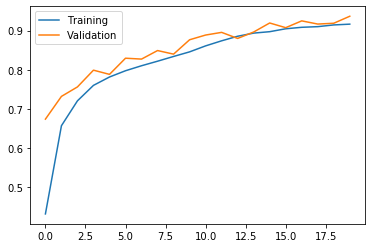

In [34]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()

---
## 1000-Element Point Clouds

In [11]:
# Point Clouds
with np.load("./datasets/mnist_point_cloud_train_1000.npz") as f:
    x_train = f[list(f.keys())[0]]
    
with np.load("./datasets/mnist_point_cloud_test_1000.npz") as f:
    x_test = f[list(f.keys())[0]]

# Labels
(_, y_train_labels), (_, y_test_labels) = keras.datasets.mnist.load_data()

# One-hot encoded labels
y_train = np.zeros((y_train_labels.size, y_train_labels.max()+1))
y_train[np.arange(y_train_labels.size), y_train_labels] = 1
y_test = np.zeros((y_test_labels.size, y_test_labels.max()+1))
y_test[np.arange(y_test_labels.size), y_test_labels] = 1

_ = None # Free memory

In [12]:
x_train.shape, x_test.shape

((60000, 1000, 2), (10000, 1000, 2))

In [13]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### Architecture

In [26]:
class PointCloudSetTransformer(keras.models.Model):
    def __init__(self):
        super(PointCloudSetTransformer, self).__init__()
        embed_dim = 64
        num_induce = 32
        num_heads = 4
        
        # Encoder
        inp = keras.layers.Input((None, 2))
        out = keras.layers.Dense(embed_dim)(inp)
        out = InducedSetAttentionBlock(embed_dim, num_heads, num_induce)(out)
        out = InducedSetAttentionBlock(embed_dim, num_heads, num_induce)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, embed_dim))
        out = keras.layers.Dropout(0.5)(inp)
        out = PoolingByMultiHeadAttention(1, embed_dim, 1)(out)
        out = keras.layers.Dropout(0.5)(out)
        out = keras.layers.Dense(10)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

In [27]:
with strategy.scope():
    model = PointCloudSetTransformer()
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

In [28]:
model.encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 2)]         0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 64)          192       
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          143616    
_________________________________________________________________
induced_set_attention_block_ (None, None, 64)          143616    
Total params: 287,424
Trainable params: 287,424
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 64)]        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
pooling_by_multihead_attenti (None, 1, 64)             21120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1, 10)             650       
Total params: 21,770
Trainable params: 21,770
Non-trainable params: 0
_________________________________________________________________


In [30]:
model(x_train[:1])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.4294261 , 0.7374056 , 0.9700136 , 3.4043715 , 0.24263896,
       0.91094553, 1.8755345 , 0.7557997 , 0.42712724, 0.9359895 ],
      dtype=float32)>

### Training

In [31]:
with strategy.scope():
    history = model.fit(x_train, y_train_labels, validation_split=0.2, epochs=20)

Epoch 1/20
1500/1500 [==============================] - 29s 18ms/step - loss: 1.7131 - sparse_categorical_accuracy: 0.3684 - val_loss: 0.9303 - val_sparse_categorical_accuracy: 0.6777
Epoch 2/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.9537 - sparse_categorical_accuracy: 0.6773 - val_loss: 0.7604 - val_sparse_categorical_accuracy: 0.7461
Epoch 3/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.7917 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.5991 - val_sparse_categorical_accuracy: 0.8027
Epoch 4/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.6866 - sparse_categorical_accuracy: 0.7755 - val_loss: 0.6042 - val_sparse_categorical_accuracy: 0.7925
Epoch 5/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.7987 - val_loss: 0.5664 - val_sparse_categorical_accuracy: 0.8138
Epoch 6/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.

In [32]:
with strategy.scope():
    model.evaluate(x_test, y_test_labels, batch_size=1)

10000/10000 [==============================] - 37s 4ms/step - loss: 0.1323 - sparse_categorical_accuracy: 0.9604


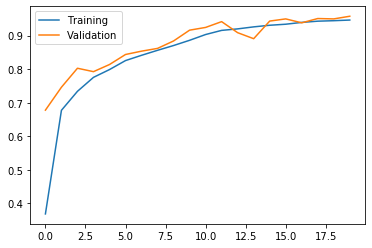

In [36]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.plot(history.history["val_sparse_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.show()